# Fuzzy c-means clustering

Fuzzy logic principles can be used to cluster multidimensional data, assigning each point a membership in each cluster center from 0 to 100 percent. This can be very powerful compared to traditional hard-thresholded clustering where every point is assigned a crisp, exact label.

Fuzzy c-means clustering is accomplished via `skfuzzy.cmeans`, and the output from this function can be repurposed to classify new data according to the calculated clusters (also known as prediction) via `skfuzzy.cmeans_predict`.






# Data generation and setup

In this example we will first undertake necessary imports, then define some test data to work with.

Text(0.5, 1.0, 'Test data: 100 points 5 clusters.')

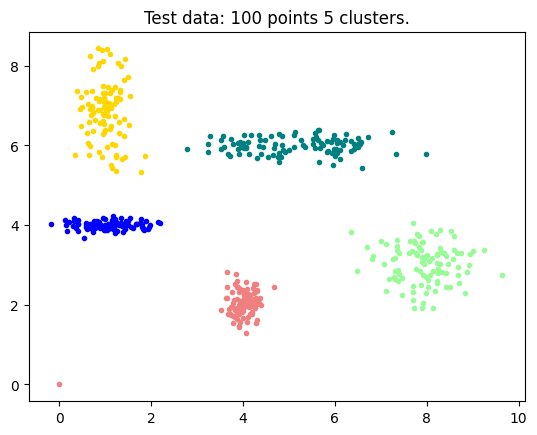

In [27]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['lightcoral', 'gold', 'teal', 'blue', 'palegreen', 'orchid', 'palegreen', 'peru','navy', 'orange']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6],
           [1, 4],
           [8, 3]
          ]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.2, 0.3],
          [0.3, 0.7],
          [1.1, 0.2],
          [0.5, 0.1],
          [0.6, 0.6]
         ]

# Generate test data
np.random.seed(32)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(100) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(100) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(100) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(5):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 100 points 5 clusters.')


# Clustering

Above is our test data. We see three distinct blobs. However, what would happen if we didn’t know how many clusters we should expect? Perhaps if the data were not so clearly clustered?
Let’s try clustering our data several times, with between 2 and 9 clusters.

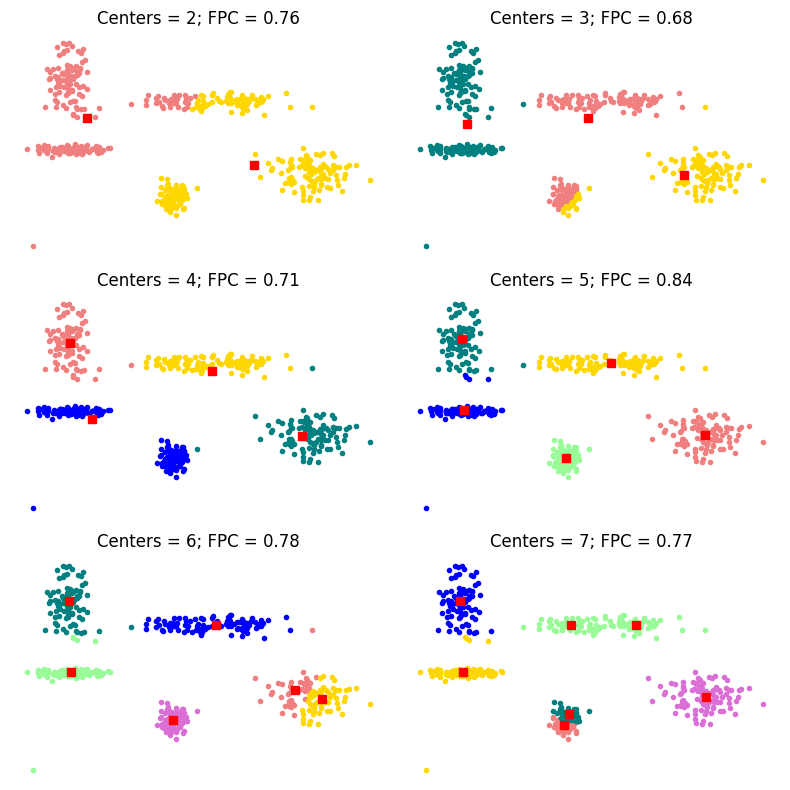

In [28]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 2, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()


# The fuzzy partition coefficient (FPC)

The FPC is defined on the range from 0 to 1, with 1 being best. It is a metric which tells us how cleanly our data is described by a certain model. Next we will cluster our set of data - which we know has three clusters - several times, with between 2 and 9 clusters. We will then show the results of the clustering, and plot the fuzzy partition coefficient. When the FPC is maximized, our data is described best.


Text(0, 0.5, 'Fuzzy partition coefficient')

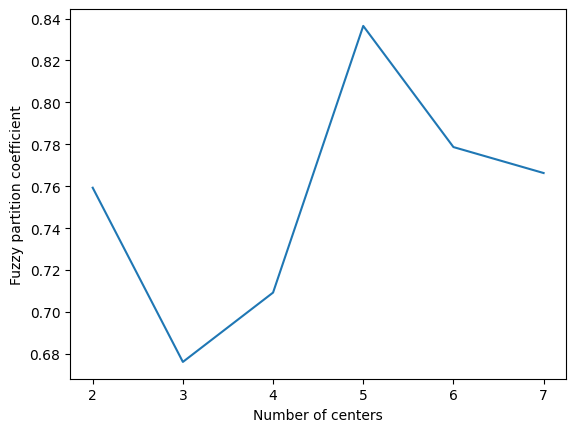

In [29]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:8], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

As we can see, the ideal number of centers is 3. This isn’t news for our contrived example, but having the FPC available can be very useful when the structure of your data is unclear.

Note that we started with two centers, not one; clustering a dataset with only one cluster center is the trivial solution and will by definition return FPC == 1.

# Classifying New Data
Now that we can cluster data, the next step is often fitting new points into an existing model. This is known as prediction. It requires both an existing model and new data to be classified.

## Building the model
We know our best model has three cluster centers. We’ll rebuild a 3-cluster model for use in prediction, generate new uniform data, and predict which cluster to which each new data point belongs.

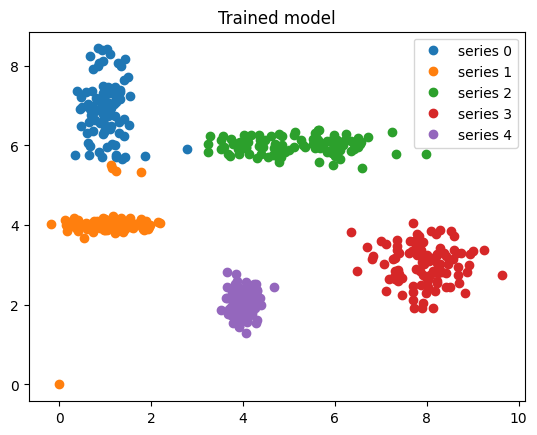

In [30]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 5, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(5):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

# Prediction

Finally, we generate uniformly sampled data over this field and classify it via `cmeans_predict`, incorporating it into the pre-existing model.

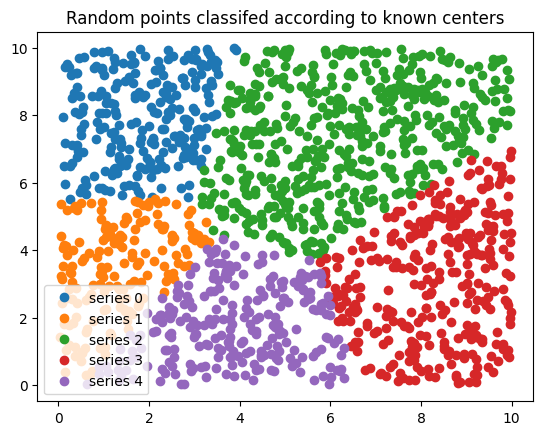

In [31]:
# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1500, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 5, error=0.005, maxiter=1000)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(5):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

Source: https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
